In [5]:
import os
import time
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from torch import optim
from scipy.ndimage import zoom
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

from utils import * 
from model import SAM_CDFFNet

In [6]:
def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description="pytorch SAM_CDFFNet training")
    parser.add_argument("--local_rank"     , default = 0, type=int,  help="")
    parser.add_argument("--dataset"        , choices = ["BJL", "L4S", "GVLM"], default="GVLM")
    parser.add_argument("--sam_pretrained_weights", default = None, type=str, help="path to SAM model pretrained weights file")
    parser.add_argument("--encoder_mode"   , default= "l")
    parser.add_argument('--modelname'      , default = 'SAM_CDFFNet', type=str, metavar='data', help='model name')
    parser.add_argument("--batch_size"     , default = 2, type=int,  help="")
    parser.add_argument("--num_classes"    , default = 1 + 1, type=int, help="加上背景")
    parser.add_argument('--epochs'         , default = 30, type=int, metavar='N', help='total epochs')
    parser.add_argument('--lr'             , default = 0.0002, type=float, help='initial learning rate')
    parser.add_argument('--lr_min'         , default = 1e-07, type=float)
    parser.add_argument('--inp_size'       , default = 1024, type=float)
    parser.add_argument('--resume'         , default = '/home/mw/work/sam_cdffnet', type=str, metavar='PATH')
    parser.add_argument("--device"         , default = 'cpu', type=str,  help="")
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M',help='momentum')

    # args = parser.parse_args()

    args = parser.parse_known_args()[0]

    return args

In [7]:
seed_everything(100)
args = parse_args()

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
sam_cdffnet = SAM_CDFFNet(args)
model = sam_cdffnet.cuda()

In [9]:
model_weight_path = r"/home/mw/work/weight/gvlm_best.pth.tar"
weight_dict = torch.load(model_weight_path, map_location='cuda')['state_dict']
model.load_state_dict(weight_dict)

<All keys matched successfully>

In [10]:
_, val_loader = make_data_loaders(args)

Training_Data : 2016    valing_Data: 514


In [12]:
evaluator = Evaluator(2)
test_reselt  = validationing(val_loader,   model,  0, evaluator, args)

In [15]:
for key, value in test_reselt.items():
    if key in ['presion','recall','F1score','mIou','Iou 1']:
        print(f" '{key}': {value:.4f},")

 'presion': 0.9126,
 'recall': 0.9369,
 'F1score': 0.9241,
 'mIou': 0.8622,
 'Iou 1': 0.7839,


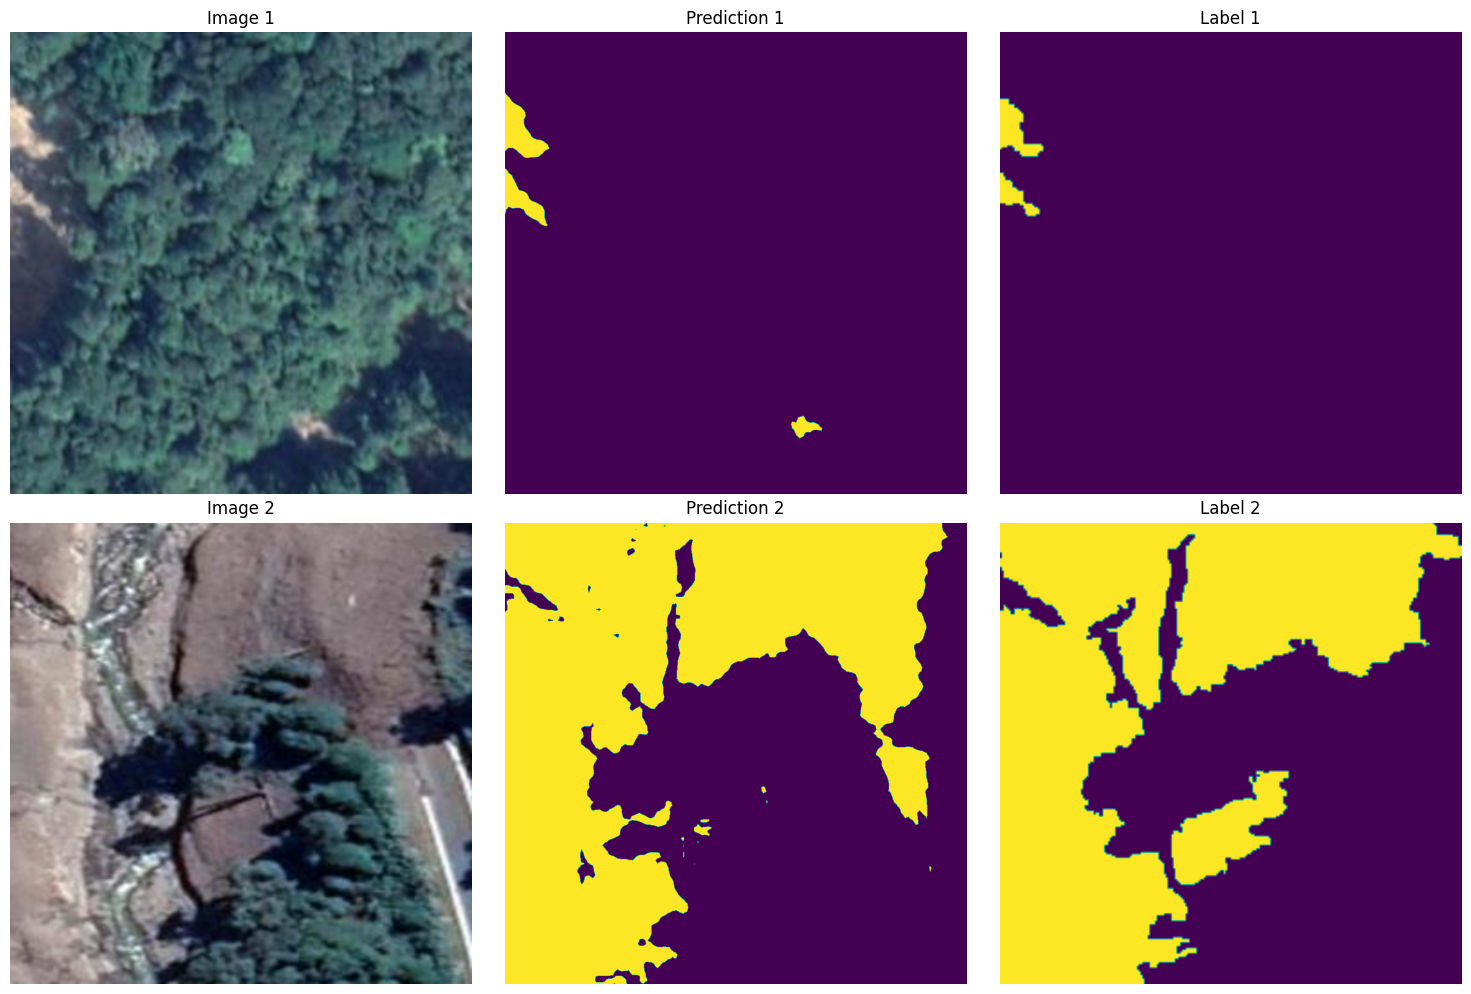

In [14]:
model.eval()

x, y = next(iter(val_loader))
rgb = x.to(args.device)
with torch.no_grad():
    output = model(rgb.float())
output[output >  0.5] = 1
output[output <= 0.5] = 0
pr = torch.squeeze(output).cpu().detach().numpy()
display_images_with_predictions_and_labels(x[0].detach().numpy(), pr[0], y[0].detach().numpy(), x[1].detach().numpy(), pr[1], y[1].detach().numpy())